In [99]:
import math
import pandas as pd
import numpy as np
import igraph 
import itertools
from itertools import chain, combinations
import matplotlib.pyplot as plt
from  sklearn.linear_model import LinearRegression
from scipy.stats import norm
from scipy.stats import chi2
import warnings
from state_space_estimation.roles import roles
%matplotlib inline

tol = 0.00001

In [4]:
class dag():
    
    def __init__(self, m):
        '''
        m is a pandas DataFrame conaining an adjacency matrix
        '''
        self.m = m
        self.nodes = self.m.columns.values
        self.lags = np.array([n for n in self.nodes if '_1' in n])
        if not all(self.m.columns.values == self.m.index.values):
            raise ValueError('Invalid adjacency matrix (columns and rows are not the same)')
        self.directed = self.directed()

            
    def parents(self, n):
        '''
        n is a node in the graph
        '''
        if n not in self.nodes:
            raise ValueError('n is not in graph')
        return self.m.loc[self.m.loc[:,n] != 0, n].index.values
    
    
    def children(self, n):
        '''
        n is a node in the graph
        '''
        if n not in self.nodes:
            raise ValueError('n is not in graph')
        return self.m.loc[:,self.m.loc[n,:] != 0].columns.values
    
    
    def directed(self):
        return utils.is_dag(self.m.values)
        
    
    def depth(self, n):
        '''
        n is a node in the graph
        return the length of the shortest path to a root node
        '''
        if not self.directed:
            raise ValueError('Cannot compute depth, graph is undirected')
        if len(self.parents(n)) == 0:
            return 0
        else:
            return 1 + max([self.depth(p) for p in self.parents(n)])
    
    
    def root_nodes(self):
        return np.array([n for n in self.nodes if len(self.parents(n)) == 0])
        
        
    def isolated_nodes(self):
        return np.array([n for n in d.nodes if (len(d.parents(n)) == 0) & (len(d.children(n)) == 0)])
    
    
    def connected_roots(self):
        return np.array([n for n in d.nodes if (len(d.parents(n)) == 0) & (len(d.children(n)) > 0)])
    
    
    def structure(self):
        M = self.m.copy()
        M[M != 0] = 1
        return M
    
    
    def shd(self, d):
        try:
            return utils.count_accuracy(d.structure().values, self.structure().values)['shd']
        except ValueError as e:
            # Graph is not directed
            return None
    
    
    def impute(self, values):
        na_nodes = values[values.isna()]
        depth = 0
        try:
            max_depth = max([self.depth(n) for n in self.nodes])
        except ValueError as e:
            print('Cannot impute values as graph is not directed')
            raise e
        while depth <= max_depth:
            for node in na_nodes.index:
                if self.depth(node) == depth:
                    values[node] = np.dot(self.m.loc[:,node], values.fillna(0))
            depth += 1
        return values


    def calculate_irf(self, x_0, T=250, verbose=False):
        if verbose:
            print('Simulating irf...')
        for lag in self.lags:
            x_0[lag] = 0
        irf = pd.DataFrame([self.impute(x_0)], columns=self.nodes)
        for t in range(T-1):
            if verbose:
                print('Simulating t={} of {} ({}%)'.format(t+1, T, np.round(100 * ((t+1)/T), decimals=2)))
            nr = pd.Series(np.full(len(self.nodes), np.nan), index=self.nodes)
            for lag in self.lags:
                nr[lag] = irf.iloc[-1,:][lag.rstrip('_1')]
            nr = self.impute(nr)    
            irf = irf.append(nr, ignore_index=True)
        irf.loc[:,'t'] = range(T)
        irf.set_index('t', inplace=True)
        irf.drop(self.lags, axis=1, inplace=True)
        return irf


    def plot_irf(self, irf, layout=None):
        if layout is None:
            side = math.ceil(math.sqrt(len(irf.columns)))
            layout = (side, side)
        axes = irf.plot(subplots=True, layout=layout, 
                        color="black", legend=False)
        for ax, name in zip(axes.flatten(), irf.columns.values):
            ax.axhline(y=0, color="red")
            ax.set_title(name)
        return plt
    
    
    def plot_structure(self):
        M = self.m.values
        g = igraph.Graph.Adjacency((M != 0.0).tolist())
        g.es['weight'] = M[M.nonzero()]
        g.vs['label'] = self.nodes
        g.vs['color'] = 'white'
        g.vs['size'] = 45
        return g

In [5]:
data = pd.read_csv('../data/rbc_100k.csv')
data = data.drop(list(['eps_z', 'eps_g']), axis=1)
data.columns = [col.replace(" ", "") for col in data.columns]
data = data.iloc[:,1:]

data = data.apply(lambda x: x - x.mean())

shift_vars = data.columns.values
shift = data.loc[:,shift_vars].shift()
shift.columns = [str(col) + '_1' for col in shift.columns]
data = pd.concat([data, shift], axis=1)
data = data.iloc[1:,:]

data_array = data.values

In [13]:
bl_children = np.where(np.isin(data.columns.values, shift.columns.values))[0]
bl_parents  = None 
d = data_array.shape[1]
bnds = [
        (0, 0)
        if i == j
        else (0, 0) 
        if bl_parents is not None and i in bl_parents
        else (0, 0) 
        if bl_children is not None and j in bl_children
        else (0, None) 
        for _ in range(2)
        for i in range(d)
        for j in range(d)
    ] 

In [9]:
pd.DataFrame(np.array(bnds))

,0,1
0,0,0
1,None,None
2,None,None
3,None,None
4,None,None
...,...,...
319,0,0
320,0,0
321,0,0
322,0,0


In [13]:
def grid_search():
    results = pd.DataFrame(columns=['SHD', 'root_nodes', 'directed', 'dag', 'params'])
    lambda1s = np.linspace(1e1, 1e-50, 10) 
    w_thresholds = np.linspace(0, 0.99, 10)
    loss_types = ['l2', 'logistic', 'poisson']
    bndss = [dag_bnds]
    params = [lambda1s, w_thresholds, loss_types, bndss]
    grid = list(itertools.product(*params))
    gridsize = len(grid)
    
    i = 1
    for p in grid:
        W_est = linear.notears_linear(data_array, 
                                      lambda1=p[0], 
                                      w_threshold=p[1],
                                      loss_type=p[2], 
                                      bnds=p[3],
                                      max_iter=1000, 
                                      h_tol=1e-8, 
                                      rho_max=1e+20)
        d = dag(pd.DataFrame(W_est, index=data.columns.values, columns=data.columns.values))
        shd = d.shd(gt)
        root_nodes = d.root_nodes()
        directed = d.directed

        results = results.append({
            'SHD': shd,
            'root_nodes': root_nodes,
            'directed': directed,
            'dag': d,
            'params': {
                'lambda1': p[0],
                'w_threshold': p[1],
                'loss_type': p[2],
                'bnds': p[3]
            }
         }, ignore_index=True)
        print('Completed iteration {} of {} ({}%)\n SHD: {}'.format(i, gridsize, np.round(i/gridsize*100, 2), shd))
        i += 1
        
        
    print('FINISHED')
    return results

In [ ]:
results = grid_search()

Completed iteration 1 of 300 (0.33%)
 SHD: None
Completed iteration 2 of 300 (0.67%)
 SHD: None
Completed iteration 3 of 300 (1.0%)
 SHD: None
Completed iteration 4 of 300 (1.33%)
 SHD: 107
Completed iteration 5 of 300 (1.67%)
 SHD: 102
Completed iteration 6 of 300 (2.0%)
 SHD: 107
Completed iteration 7 of 300 (2.33%)
 SHD: 104
Completed iteration 8 of 300 (2.67%)
 SHD: 102
Completed iteration 9 of 300 (3.0%)
 SHD: 105
Completed iteration 10 of 300 (3.33%)
 SHD: 102
Completed iteration 11 of 300 (3.67%)
 SHD: 102
Completed iteration 12 of 300 (4.0%)
 SHD: 101
Completed iteration 13 of 300 (4.33%)
 SHD: 98
Completed iteration 14 of 300 (4.67%)
 SHD: 102
Completed iteration 15 of 300 (5.0%)
 SHD: 97
Completed iteration 16 of 300 (5.33%)
 SHD: 94
Completed iteration 17 of 300 (5.67%)
 SHD: 103
Completed iteration 18 of 300 (6.0%)
 SHD: 97
Completed iteration 19 of 300 (6.33%)
 SHD: 93
Completed iteration 20 of 300 (6.67%)
 SHD: 103
Completed iteration 21 of 300 (7.0%)
 SHD: 96
Completed i

Completed iteration 170 of 300 (56.67%)
 SHD: 101
Completed iteration 171 of 300 (57.0%)
 SHD: 98
Completed iteration 172 of 300 (57.33%)
 SHD: 95
Completed iteration 173 of 300 (57.67%)
 SHD: 101
Completed iteration 174 of 300 (58.0%)
 SHD: 97
Completed iteration 175 of 300 (58.33%)
 SHD: 95
Completed iteration 176 of 300 (58.67%)
 SHD: 100
Completed iteration 177 of 300 (59.0%)
 SHD: 93
Completed iteration 178 of 300 (59.33%)
 SHD: 97
Completed iteration 179 of 300 (59.67%)
 SHD: 101
Completed iteration 180 of 300 (60.0%)
 SHD: 91
Completed iteration 181 of 300 (60.33%)
 SHD: None
Completed iteration 182 of 300 (60.67%)
 SHD: None
Completed iteration 183 of 300 (61.0%)
 SHD: None
Completed iteration 184 of 300 (61.33%)
 SHD: 105
Completed iteration 185 of 300 (61.67%)
 SHD: 99
Completed iteration 186 of 300 (62.0%)
 SHD: 104
Completed iteration 187 of 300 (62.33%)
 SHD: 103
Completed iteration 188 of 300 (62.67%)
 SHD: 99
Completed iteration 189 of 300 (63.0%)
 SHD: 102
Completed ite

In [9]:
results = results[results['directed']].sort_values(by='SHD')

In [42]:
W_est = linear.notears_linear(data_array, 
                              lambda1=1e-1, 
                              w_threshold=0.001,
                              loss_type='poisson', 
                              max_iter=1000, 
                              h_tol=1e-30, 
                              rho_max=1e+30,
                              bnds=bnds)
                              # verbose=True)
adj_df = pd.DataFrame(W_est, index=data.columns.values, columns=data.columns.values)
d = dag(adj_df)

C:\Users\ehall\Documents\thesis\bayesian_networks\python\notears_original\linear.py:33: RuntimeWarning: overflow encountered in exp
  S = np.exp(M)
C:\Users\ehall\Documents\thesis\bayesian_networks\python\notears_original\linear.py:35: RuntimeWarning: invalid value encountered in matmul
  G_loss = 1.0 / X.shape[0] * X.T @ (S - X)
C:\Users\ehall\Documents\thesis\bayesian_networks\python\notears_original\linear.py:59: RuntimeWarning: overflow encountered in double_scalars
  obj = loss + 0.5 * rho * h * h + alpha * h + lambda1 * w.sum()
C:\Users\ehall\Documents\thesis\bayesian_networks\python\notears_original\linear.py:60: RuntimeWarning: overflow encountered in multiply
  G_smooth = G_loss + (rho * h + alpha) * G_h


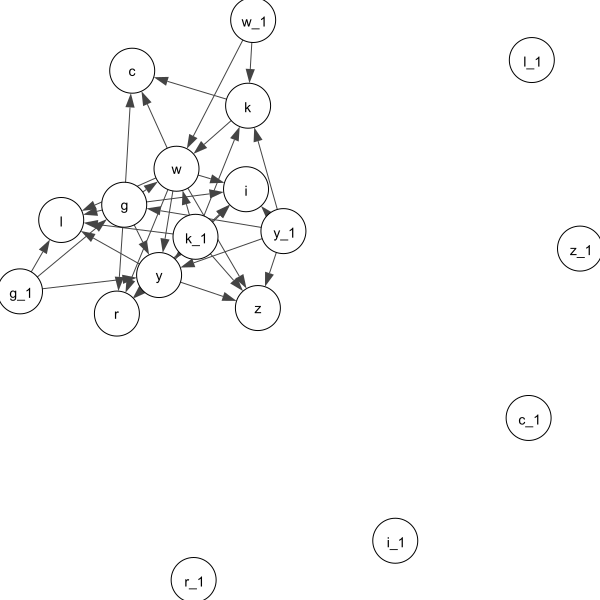

In [43]:
g = d.plot_structure()
igraph.plot(g)

In [218]:
d = len(data.columns)
gt = pd.DataFrame(np.zeros((d, d)), columns=data.columns, index=data.columns)

gt.loc['z','y'] = 1.37278195
gt.loc['g','y'] = 0.15452990
gt.loc['k_1','y'] = 0.01074088

gt.loc['z','c'] = 0.35193460
gt.loc['g','c'] = -0.10362034
gt.loc['k_1','c'] = 0.03140616

gt.loc['z','k'] = 1.01252958
gt.loc['g','k'] = 0.04465323
gt.loc['k_1','k'] = 0.95566049

gt.loc['z','l'] = 0.154009373
gt.loc['g','l'] = 0.072779801
gt.loc['k_1','l'] = -0.009885726

gt.loc['z','r'] = 0.16661011
gt.loc['g','r'] = 0.01875479
gt.loc['k_1','r'] = -0.01036630

gt.loc['z','w'] = 1.79625183
gt.loc['g','w'] = -0.15452990
gt.loc['k_1','w'] = 0.08541297

gt.loc['z','i'] = 1.02084736
gt.loc['g','i'] = 0.04502005
gt.loc['k_1','i'] = -0.02066529

gt.loc['z_1','z'] = 0.9702133
gt.loc['g_1','g'] = 0.989444

gt_dag = dag(gt)

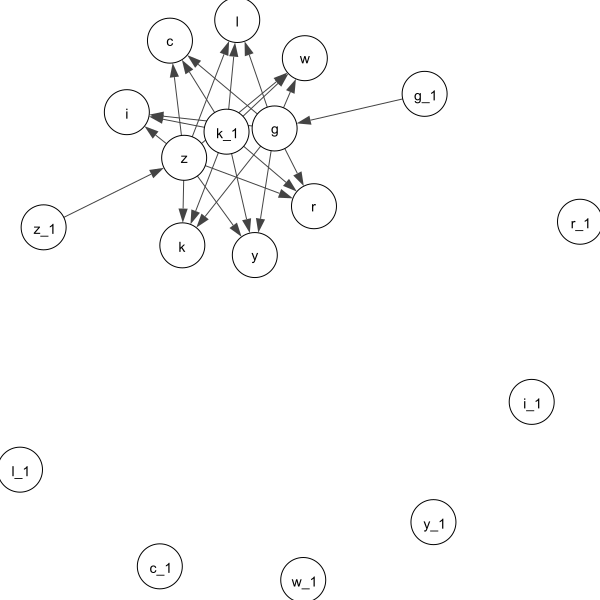

In [242]:
g = gt_dag.plot_structure()
igraph.plot(g)

In [32]:
x_0 = pd.Series(np.full(len(gt_dag.nodes), np.nan), index=gt_dag.nodes)
shock_amt = 0.66
x_0[4] = shock_amt
x_0[9:] = 0

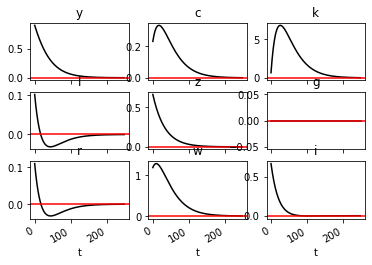

In [244]:
tru_irf = gt_dag.calculate_irf(x_0, T=250)
plt = gt_dag.plot_irf(irf)
plt.show()

In [41]:
est_irf = d.calculate_irf(x_0, T=250, verbose = True)
plt = d.plot_irf(est_irf)
plt.show()

Simulating irf...
Cannot impute values as graph is not directed


ValueError: Cannot compute depth, graph is undirected

In [34]:
max([d.depth(n) for n in d.nodes])

9

In [38]:
d.m

,y,c,k,l,z,g,r,w,i,y_1,c_1,k_1,l_1,z_1,g_1,r_1,w_1,i_1
y,0.000000,0.000000,0.000000,0.150903,0.000000,0.565579,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c,-0.108084,0.000000,0.194203,-0.109703,-0.001145,-0.350236,0.000000,0.304725,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
k,0.287116,0.000000,0.000000,0.017055,0.193318,0.184063,0.000000,0.267714,0.179391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
l,0.000000,0.000000,0.000000,0.000000,0.000000,0.234266,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
z,0.126353,0.000000,0.000000,0.014922,0.000000,0.008054,0.000000,0.000000,0.248221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
g,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
r,0.039608,0.174512,0.010524,0.006119,0.000000,0.050724,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
w,-0.074430,0.000000,0.000000,-0.036359,0.144925,-0.536294,0.000000,0.000000,0.058104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
i,0.211528,0.000000,0.000000,0.000000,0.000000,0.083194,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
y_1,0.012524,0.014206,-0.011540,0.007737,0.006459,-0.002468,0.032153,0.000000,0.013288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
from scipy import stats, linalg
from itertools import chain, combinations, product
from sklearn.linear_model import LinearRegression, Lasso

In [3]:
data = pd.read_csv('../data/real_data.csv')
data = data.drop(list(['DATE']), axis=1)
data.columns = [col.replace(" ", "") for col in data.columns]
data = data.iloc[:,1:]

# data = data.iloc[:1000,:]
data = data.apply(lambda x: x - x.mean())
# data = data.applymap(lambda x: x + np.random.normal(scale=1))

shift_vars = data.columns.values
shift = data.loc[:,shift_vars].shift()
shift.columns = [str(col) + '_1' for col in shift.columns]
data = pd.concat([data, shift], axis=1)
data = data.iloc[1:,:]

In [4]:
def partial_correlation(y, x, z, data):
    if len(z) == 0:
        pcorr = stats.pearsonr(data[y], data[x])[0]
    else:
        model_y = LinearRegression(fit_intercept=False, normalize=True)
        model_x = LinearRegression(fit_intercept=False, normalize=True)
        model_y.fit(data[z], data[y])
        model_x.fit(data[z], data[x])
        resid_y = data[y] - model_y.predict(data[z])
        resid_x = data[x] - model_x.predict(data[z])
    
        pcorr = stats.pearsonr(resid_y, resid_x)[0]
    
    return pcorr

In [5]:
def powerset(iterable):
    s = list(iterable)
    pset = list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))
    variables = iterable[:np.int64(len(iterable)/2)]
    pairs = {}
    for v in variables:
        pairs[v] = v+'_1'
        pairs[v+'_1'] = v
    pset = [s for s in pset if all([pairs[n] not in s for n in s])]
    return pset
        

def choose_states(data, verbose=False):
    lags = data.columns.values[np.int64(len(data.columns.values)/2):]
    results = pd.DataFrame(columns=['states', 'mean_pcorr', 'min_pcorr', 'max_pcorr', 'pcorrs'])
    for states in powerset(data.columns.values):
        controls = [n for n in data.columns.values if n not in states and n not in lags]
        if len(controls) < 2:
            break
        if verbose: 
            print('Calculating partial correlations for {}'.format(list(states)))
        pcorrs = []
        for p in product(controls, repeat=2):
            pcorr = partial_correlation(p[0], p[1], list(states), data=data)
            entry = {'y': p[0],
                     'x': p[1],
                     'z': states,
                     'pcorr': pcorr}
            pcorrs.append(entry)
        result = {'states': list(states),
                  'mean_pcorr': np.mean(np.abs([p['pcorr'] for p in pcorrs])),
                  'min_pcorr': min([p['pcorr'] for p in pcorrs]),
                  'max_pcorr': max([p['pcorr'] for p in pcorrs]),
                  'pcorrs': pcorrs}
        results = results.append(result, ignore_index=True)
    return results

In [7]:
results = choose_states(data, verbose=True)
results

MemoryError: 

In [106]:
results['nstates'] = results['states'].apply(lambda x: len(x))
results.sort_values(by=['mean_pcorr', 'nstates'], ascending=[False, True])

,states,mean_pcorr,min_pcorr,max_pcorr,pcorrs,nstates
178,"[y, k, z]",1.000000,-1.000000,1.0,"[{'y': 'c', 'x': 'c', 'z': ('y', 'k', 'z'), 'p...",3
180,"[y, k, r]",1.000000,-1.000000,1.0,"[{'y': 'c', 'x': 'c', 'z': ('y', 'k', 'r'), 'p...",3
182,"[y, k, i]",1.000000,-1.000000,1.0,"[{'y': 'c', 'x': 'c', 'z': ('y', 'k', 'i'), 'p...",3
190,"[y, l, z]",1.000000,-1.000000,1.0,"[{'y': 'c', 'x': 'c', 'z': ('y', 'l', 'z'), 'p...",3
191,"[y, l, g]",1.000000,-1.000000,1.0,"[{'y': 'c', 'x': 'c', 'z': ('y', 'l', 'g'), 'p...",3
...,...,...,...,...,...,...
14670,"[c, l, r, i, y_1, k_1, g_1]",0.395354,-0.473829,1.0,"[{'y': 'y', 'x': 'y', 'z': ('c', 'l', 'r', 'i'...",7
12938,"[y, k, l, z, g, w, r_1]",0.390233,-0.149578,1.0,"[{'y': 'c', 'x': 'c', 'z': ('y', 'k', 'l', 'z'...",7
15052,"[c, r, i, y_1, k_1, l_1, w_1]",0.387022,-0.695665,1.0,"[{'y': 'y', 'x': 'y', 'z': ('c', 'r', 'i', 'y_...",7
7168,"[y, c, z, g, r, i_1]",0.371170,-0.480193,1.0,"[{'y': 'k', 'x': 'k', 'z': ('y', 'c', 'z', 'g'...",6


In [107]:
results[results['mean_pcorr'] == 1]

,states,mean_pcorr,min_pcorr,max_pcorr,pcorrs,nstates
178,"[y, k, z]",1.0,-1.0,1.0,"[{'y': 'c', 'x': 'c', 'z': ('y', 'k', 'z'), 'p...",3
180,"[y, k, r]",1.0,-1.0,1.0,"[{'y': 'c', 'x': 'c', 'z': ('y', 'k', 'r'), 'p...",3
182,"[y, k, i]",1.0,-1.0,1.0,"[{'y': 'c', 'x': 'c', 'z': ('y', 'k', 'i'), 'p...",3
190,"[y, l, z]",1.0,-1.0,1.0,"[{'y': 'c', 'x': 'c', 'z': ('y', 'l', 'z'), 'p...",3
191,"[y, l, g]",1.0,-1.0,1.0,"[{'y': 'c', 'x': 'c', 'z': ('y', 'l', 'g'), 'p...",3
...,...,...,...,...,...,...
16797,"[w, c_1, k_1, l_1, z_1, g_1, i_1]",1.0,-1.0,1.0,"[{'y': 'y', 'x': 'y', 'z': ('w', 'c_1', 'k_1',...",7
16798,"[w, c_1, k_1, l_1, z_1, r_1, i_1]",1.0,-1.0,1.0,"[{'y': 'y', 'x': 'y', 'z': ('w', 'c_1', 'k_1',...",7
16799,"[w, c_1, k_1, l_1, g_1, r_1, i_1]",1.0,-1.0,1.0,"[{'y': 'y', 'x': 'y', 'z': ('w', 'c_1', 'k_1',...",7
16800,"[w, c_1, k_1, z_1, g_1, r_1, i_1]",1.0,-1.0,1.0,"[{'y': 'y', 'x': 'y', 'z': ('w', 'c_1', 'k_1',...",7


In [51]:
results[(np.abs(results['min_pcorr']) > 0.999) & (results['max_pcorr'] > 0.999)].sort_values(by='mean_pcorr')

,states,mean_pcorr,min_pcorr,max_pcorr,pcorrs
34,"[l_1, w_1]",0.632012,-0.999702,1.0,"[{'y': 'y', 'x': 'y', 'z': ('l_1', 'w_1'), 'pc..."
117,"[l_1, r_1, w_1]",0.632099,-0.999621,1.0,"[{'y': 'y', 'x': 'y', 'z': ('l_1', 'r_1', 'w_1..."
8,[w_1],0.632539,-0.999784,1.0,"[{'y': 'y', 'x': 'y', 'z': ('w_1',), 'pcorr': ..."
43,"[r_1, w_1]",0.632657,-0.999757,1.0,"[{'y': 'y', 'x': 'y', 'z': ('r_1', 'w_1'), 'pc..."
83,"[c_1, l_1, w_1]",0.712288,-0.999508,1.0,"[{'y': 'y', 'x': 'y', 'z': ('c_1', 'l_1', 'w_1..."
...,...,...,...,...,...
471,"[y_1, c_1, k_1, l_1, z_1, w_1, i_1]",0.964895,-0.999963,1.0,"[{'y': 'y', 'x': 'y', 'z': ('y_1', 'c_1', 'k_1..."
511,"[y_1, c_1, k_1, l_1, z_1, g_1, r_1, w_1, i_1]",0.967125,-0.999889,1.0,"[{'y': 'y', 'x': 'y', 'z': ('y_1', 'c_1', 'k_1..."
504,"[y_1, c_1, k_1, l_1, z_1, g_1, w_1, i_1]",0.967141,-0.999890,1.0,"[{'y': 'y', 'x': 'y', 'z': ('y_1', 'c_1', 'k_1..."
507,"[y_1, c_1, k_1, z_1, g_1, r_1, w_1, i_1]",0.967155,-0.999892,1.0,"[{'y': 'y', 'x': 'y', 'z': ('y_1', 'c_1', 'k_1..."


In [52]:
results['score'] = results['mean_pcorr'] / len(results['states'])

In [54]:
results.sort_values(by='states')

,states,mean_pcorr,min_pcorr,max_pcorr,pcorrs,score
0,[],0.552269,-0.337173,1.0,"[{'y': 'y', 'x': 'y', 'z': (), 'pcorr': 1.0}, ...",0.001079
2,[c_1],0.503798,-0.237527,1.0,"[{'y': 'y', 'x': 'y', 'z': ('c_1',), 'pcorr': ...",0.000984
21,"[c_1, g_1]",0.443734,-0.995356,1.0,"[{'y': 'y', 'x': 'y', 'z': ('c_1', 'g_1'), 'pc...",0.000867
91,"[c_1, g_1, i_1]",0.442232,-0.958123,1.0,"[{'y': 'y', 'x': 'y', 'z': ('c_1', 'g_1', 'i_1...",0.000864
89,"[c_1, g_1, r_1]",0.443990,-0.995359,1.0,"[{'y': 'y', 'x': 'y', 'z': ('c_1', 'g_1', 'r_1...",0.000867
...,...,...,...,...,...,...
124,"[z_1, r_1, i_1]",0.654064,-0.851553,1.0,"[{'y': 'y', 'x': 'y', 'z': ('z_1', 'r_1', 'i_1...",0.001277
123,"[z_1, r_1, w_1]",0.721210,-0.999210,1.0,"[{'y': 'y', 'x': 'y', 'z': ('z_1', 'r_1', 'w_1...",0.001409
254,"[z_1, r_1, w_1, i_1]",0.737689,-0.992015,1.0,"[{'y': 'y', 'x': 'y', 'z': ('z_1', 'r_1', 'w_1...",0.001441
38,"[z_1, w_1]",0.721209,-0.999356,1.0,"[{'y': 'y', 'x': 'y', 'z': ('z_1', 'w_1'), 'pc...",0.001409


In [2]:
from sklearn.linear_model import Lasso, LinearRegression

In [3]:
Y = data.iloc[:,:9]
X = data.iloc[:,9:]

NameError: name 'data' is not defined

In [115]:
model = Lasso(alpha=0.1, max_iter=10000, fit_intercept = False, normalize = True)
model.fit(X, Y)

Lasso(alpha=0.1, fit_intercept=False, max_iter=10000, normalize=True)

In [116]:
# Each row is coefs for y_i
lasso_results = pd.DataFrame(model.coef_, columns=X.columns, index=Y.columns)

In [117]:
lasso_results.loc[:,(lasso_results != 0).any()].columns.values

array(['y_1', 'k_1', 'l_1', 'z_1', 'g_1', 'w_1'], dtype=object)

In [132]:
def lasso_grid_search(X, Y, a_min=-5, a_max=5, T=100, verbose=True, **kwargs):
    results = pd.DataFrame(columns=['alpha', 'states', 'coefs', 'model'])
    i = 1
    for alpha in np.logspace(a_min, a_max, T):
        if verbose:
            print('Beginning iteration {} of {} ({}%) --- alpha = {}'.format(i, T, (i/T)*100, alpha))
        model = Lasso(alpha=alpha, **kwargs)
        model.fit(X, Y)
        coefs = pd.DataFrame(model.coef_, columns=X.columns, index=Y.columns)
        states = coefs.loc[:,(coefs != 0).any()].columns.values
        result = {'alpha': alpha, 'states': states, 'coefs': coefs, 'model': model}
        results = results.append(result, ignore_index=True)
        i += 1
    return results

In [133]:
lasso_results = lasso_grid_search(X, Y, T=100, max_iter=100000, fit_intercept = False, normalize = True)

Beginning iteration 1 of 100 (1.0%) --- alpha = 1e-05
Beginning iteration 2 of 100 (2.0%) --- alpha = 1.2618568830660211e-05
Beginning iteration 3 of 100 (3.0%) --- alpha = 1.5922827933410938e-05
Beginning iteration 4 of 100 (4.0%) --- alpha = 2.0092330025650458e-05
Beginning iteration 5 of 100 (5.0%) --- alpha = 2.5353644939701114e-05
Beginning iteration 6 of 100 (6.0%) --- alpha = 3.199267137797385e-05
Beginning iteration 7 of 100 (7.000000000000001%) --- alpha = 4.037017258596558e-05
Beginning iteration 8 of 100 (8.0%) --- alpha = 5.0941380148163754e-05
Beginning iteration 9 of 100 (9.0%) --- alpha = 6.428073117284319e-05
Beginning iteration 10 of 100 (10.0%) --- alpha = 8.111308307896872e-05
Beginning iteration 11 of 100 (11.0%) --- alpha = 0.00010235310218990269
Beginning iteration 12 of 100 (12.0%) --- alpha = 0.0001291549665014884
Beginning iteration 13 of 100 (13.0%) --- alpha = 0.00016297508346206434
Beginning iteration 14 of 100 (14.000000000000002%) --- alpha = 0.00020565123

In [136]:
for states in lasso_results['states']:
    print(states)

['y_1' 'c_1' 'k_1' 'l_1' 'z_1' 'g_1' 'r_1' 'w_1' 'i_1']
['y_1' 'c_1' 'k_1' 'l_1' 'z_1' 'g_1' 'r_1' 'w_1' 'i_1']
['y_1' 'c_1' 'k_1' 'l_1' 'z_1' 'g_1' 'r_1' 'w_1' 'i_1']
['y_1' 'c_1' 'k_1' 'l_1' 'z_1' 'g_1' 'r_1' 'w_1' 'i_1']
['y_1' 'c_1' 'k_1' 'l_1' 'z_1' 'g_1' 'r_1' 'w_1' 'i_1']
['y_1' 'c_1' 'k_1' 'l_1' 'z_1' 'g_1' 'r_1' 'w_1' 'i_1']
['y_1' 'c_1' 'k_1' 'l_1' 'z_1' 'g_1' 'r_1' 'w_1' 'i_1']
['y_1' 'c_1' 'k_1' 'l_1' 'z_1' 'g_1' 'r_1' 'w_1' 'i_1']
['y_1' 'c_1' 'k_1' 'l_1' 'z_1' 'g_1' 'r_1' 'w_1' 'i_1']
['y_1' 'c_1' 'k_1' 'l_1' 'z_1' 'g_1' 'r_1' 'w_1' 'i_1']
['y_1' 'c_1' 'k_1' 'l_1' 'z_1' 'g_1' 'r_1' 'w_1' 'i_1']
['y_1' 'c_1' 'k_1' 'l_1' 'z_1' 'g_1' 'r_1' 'w_1' 'i_1']
['y_1' 'c_1' 'k_1' 'l_1' 'z_1' 'g_1' 'r_1' 'w_1' 'i_1']
['y_1' 'c_1' 'k_1' 'l_1' 'z_1' 'g_1' 'r_1' 'w_1' 'i_1']
['y_1' 'c_1' 'k_1' 'l_1' 'z_1' 'g_1' 'r_1' 'w_1' 'i_1']
['y_1' 'c_1' 'k_1' 'l_1' 'z_1' 'g_1' 'r_1' 'w_1' 'i_1']
['y_1' 'c_1' 'k_1' 'l_1' 'z_1' 'g_1' 'r_1' 'w_1' 'i_1']
['y_1' 'c_1' 'k_1' 'l_1' 'z_1' 'g_1' 'r_1' 'w_1'

In [ ]:
def calculate_irf(model, x_0, states, lags, T=250, verbose=False):
    if verbose:
        print('Simulating irf...')
    for lag in lags:
        x_0[lag] = 0
    irf = pd.DataFrame([self.impute(x_0)], columns=self.nodes)
    for t in range(T-1):
        if verbose:
            print('Simulating t={} of {} ({}%)'.format(t+1, T, np.round(100 * ((t+1)/T), decimals=2)))
        nr = pd.Series(np.full(len(self.nodes), np.nan), index=self.nodes)
        for lag in self.lags:
            nr[lag] = irf.iloc[-1,:][lag.rstrip('_1')]
        nr = self.impute(nr)    
        irf = irf.append(nr, ignore_index=True)
    irf.loc[:,'t'] = range(T)
    irf.set_index('t', inplace=True)
    irf.drop(self.lags, axis=1, inplace=True)
    return irf
    

def plot_irfs(states, lags, data, T=250, **kwargs):
    Y = data[~np.union1d(states, lags)]
    X = data[states]
    model = LinearRegression(**kwargs)
    model.fit(X, Y)
    irf = pd.DataFrame(columns=data.columns)
    irf 
    for t in range(T):
        

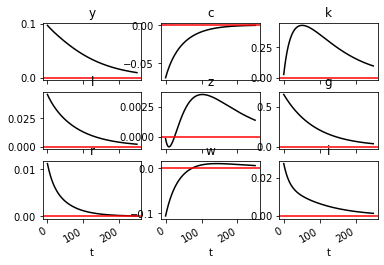

In [216]:
T = 250
states = np.array(['k_1', 'g_1', 'z_1'])
X_0 = np.array([[0, 0.66 , 0]]) # initial values of states
controls = data.columns.values[:9]
lags = data.columns.values[9:]
# Note: For now assume states are lags (can relax later i.e. z_1 -> z -> controls)

Y = data[controls]
X = data[states]
model = LinearRegression(fit_intercept=False, normalize=True)
model.fit(X, Y)

controls_init = pd.Series(model.predict(X_0).reshape(len(controls)), index=controls)
lags_init = pd.Series(np.zeros(len(lags)), index=lags)
for i in range(len(states)):
    lags_init[states[i]] = X_0[0, i]
irf = pd.DataFrame(controls_init.append(lags_init)).T
for t in range(1, T):
    L = irf.iloc[-1,:][controls]
    L.index = lags
    S = np.array([L[states]])
    C = pd.Series(model.predict(S).reshape(len(controls)), index=controls)
    irf = irf.append(C.append(L), ignore_index=True)
    
irf.loc[:,'t'] = range(T)
irf.set_index('t', inplace=True)
irf.drop(lags, axis=1, inplace=True)

side = math.ceil(math.sqrt(len(irf.columns)))
layout = (side, side)
axes = irf.plot(subplots=True, layout=layout, 
                color="black", legend=False)
for ax, name in zip(axes.flatten(), irf.columns.values):
    ax.axhline(y=0, color="red")
    ax.set_title(name)
plt.show()

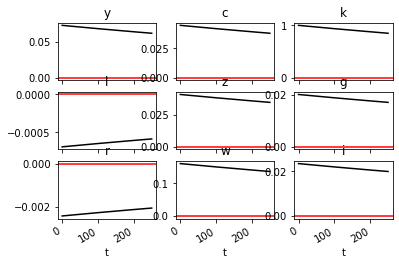

In [223]:
T = 250
states = np.array(['k_1'])
X_0 = np.array([[1]]) # initial values of states
controls = data.columns.values[:9]
lags = data.columns.values[9:]
# Note: For now assume states are lags (can relax later i.e. z_1 -> z -> controls)

Y = data[controls]
X = data[states]
model = LinearRegression(fit_intercept=False, normalize=True)
model.fit(X, Y)

controls_init = pd.Series(model.predict(X_0).reshape(len(controls)), index=controls)
lags_init = pd.Series(np.zeros(len(lags)), index=lags)
for i in range(len(states)):
    lags_init[states[i]] = X_0[0, i]
irf = pd.DataFrame(controls_init.append(lags_init)).T
for t in range(1, T):
    L = irf.iloc[-1,:][controls]
    L.index = lags
    S = np.array([L[states]])
    C = pd.Series(model.predict(S).reshape(len(controls)), index=controls)
    irf = irf.append(C.append(L), ignore_index=True)
    
irf.loc[:,'t'] = range(T)
irf.set_index('t', inplace=True)
irf.drop(lags, axis=1, inplace=True)

side = math.ceil(math.sqrt(len(irf.columns)))
layout = (side, side)
axes = irf.plot(subplots=True, layout=layout, 
                color="black", legend=False)
for ax, name in zip(axes.flatten(), irf.columns.values):
    ax.axhline(y=0, color="red")
    ax.set_title(name)
plt.show()

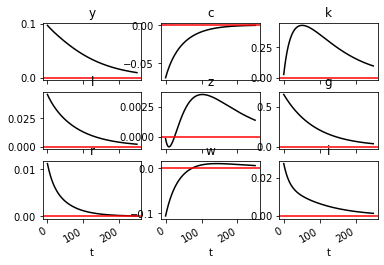

In [220]:
x_0 = pd.Series(np.full(len(gt_dag.nodes), np.nan), index=gt_dag.nodes)
shock_amt = 1.04
x_0[5] = shock_amt
x_0[9:] = 0
tru_irf = gt_dag.calculate_irf(x_0, T=250)
plt = gt_dag.plot_irf(irf)
plt.show()

In [119]:
import numpy as np
from itertools import combinations
from sklearn.linear_model import LinearRegression
from scipy import stats
import warnings


def srivastava(data):
    '''
    Inputs:
        data: np.ndarray
            Residual correlation matrix
    Performs:
        Perform test T3* from Srivastava (2005) to test wheter
        the corrleation matrix is diagonal
    Returns:
        float
    '''
    n = data.shape[0]
    p = data.shape[1]
    if p > 1:
        S = np.cov(data.T)
        a2_hat = np.sum(np.square(np.diag(S)))
        a4_hat = np.sum(np.power(np.diag(S), 4))
        a20_hat = (n/(p*(n+2)))*a2_hat
        a40_hat = (1/p)*a4_hat
        g3_hat = (n/(n-1))*((np.trace(np.dot(S,S))-(1/n)*(np.trace(S))**2)/(np.sum(np.square(np.diag(S)))))

        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            T3_hat = (n/2)*((g3_hat-1)/np.sqrt(1-(1/p)*(a40_hat/(a20_hat**2))))
            if np.isnan(T3_hat): # Could have sqrt of negative, replace as in Wang et al.
                T3_hat = (n/2)*((g3_hat-1)/np.sqrt(1-(a4_hat/(a2_hat**2))))

        return T3_hat
    else: # Test isn't meaningful, so do not exclude the model on this basis
        return 0        


def schott(data):
    '''
    Inputs:
        data: np.ndarray
            Residual correlation matrix
    Performs:
        Perform test from Schott (2005) to test wheter
        the corrleation matrix is diagonal
    Returns:
        float
    '''
    n = data.shape[0]
    m = data.shape[1]
    k = m*(m-1)/2
    if m > 1:
        R = np.corrcoef(data.T)
        # for i,j in combinations(list(range(R.shape[0])), 2):
        #     if np.abs(R[i,j]) == 1 and i != j:
        #         R[i,j] == 0
        t_nm = np.sum(np.square(np.triu(R, k=1))) - ((m*(m-1))/(2*n))
        s_nm = (m*(m-1)*(n-1))/((n**2)*(n+2))

        return t_nm/np.sqrt(s_nm)
    
    else: # Test isn't meaningful, so do not exclude the model on this basis
        return 0


def get_resids(roles, data):
    '''
    Inputs:
        roles: state_space_estimation.roles
        data: pd.DataFrame
    Performs:
        Collect linear regression residuals from the model specified in roles
    Returns:
        (np.ndarray, np.ndarray)
    '''
    # Use numpy indexing instead of pandas for large performance increase
    # (At the expense of some increased code complexity)
    data = data.values
    
    # Conditioning sets
    cset = np.append(roles.lag_2_endo_states_idx, roles.lag_exo_states_idx)
    # cset = np.append(roles.lag_endo_states_idx, roles.exo_states_idx)
    
    # Targets 
    tar = np.append(np.append(roles.lag_endo_states_idx, roles.lag_controls_idx), roles.exo_states_idx)
    # tar = np.append(roles.endo_states_idx, roles.controls_idx)
    
    if cset.shape[0] > 0:
        lm = LinearRegression(fit_intercept=True, normalize=False)
        lm.fit(data[:,cset], data[:,tar])
        resid = data[:,tar] - lm.predict(data[:,cset]) 
    else:
        resid = data[:,tar]
    
    return resid


def test(roles, data, method='schott', alpha=0.05, tol=1e-20):
    '''
    Inputs:
        roles: state_space_estimation.roles
            Model upon which to conduct constraint tests
        data: pd.DataFrame
        method: one of ('srivastava', 'schott')
            Testing strategy to use
        alpha: float
            Significance level
        tol: float
            Tolerence, used for detecting near zero residuals 
            which make testing unstable
    Performs:
        Conduct constraint-based (partial correlation) tests on data
        given the state-space model specified by roles and return all
        tests in a dictionary (two test statistics, two p-values, and
        overall decision 'valid')
    Returns:
        tests: dict
    '''
    valid = True
    resid = get_resids(roles, data)
    if method == 'srivastava':
        t = srivastava(resid)
        crit_val = stats.norm.ppf(1-(alpha)) # One-sided test
        p = 1 - stats.norm.cdf(t)
        if t > crit_val:
            valid = False

    elif method == 'schott':
        t = schott(resid)
        crit_val = stats.norm.ppf(1-(alpha/2)) # Two-sided test
        p = 2*(1 - stats.norm.cdf(np.abs(t)))
        if np.abs(t) > crit_val:
            valid = False
        
    else:
        raise ValueError('method {} not found'.format(method))

    return {'t': t, 'p': p, 'valid': valid}

In [123]:
data = pd.read_csv('../data/rbc.csv')
# data.set_index('DATE', inplace=True)

In [148]:
model = roles(['z', 'g'], ['k'], ['y', 'c', 'l', 'r', 'w', 'i'], data.columns.values)
sample = data.sample(1000, replace=True)
print(test(model, sample, method='srivastava'))
print(test(model, sample, method='schott'))

{'t': 0.2343358341554494, 'p': 0.4073621343171262, 'valid': True}
{'t': 623.1470202894891, 'p': 0.0, 'valid': False}


In [15]:
data

,y,c,k,l,z,g,r,w,i,y_1,...,i_1,y_2,c_2,k_2,l_2,z_2,g_2,r_2,w_2,i_2
0,-0.432660,-0.328114,0.568709,0.035532,-0.518120,1.729024,-0.064919,-1.107044,-0.473053,-1.073686,...,-0.939530,-0.798665,-0.218970,2.044149,-0.084096,-0.678738,0.664790,-0.129923,-1.080448,-0.721381
1,-0.966827,-0.469972,-0.289636,-0.022493,-0.896087,1.664389,-0.123976,-1.818233,-0.851587,-0.432660,...,-0.473053,-1.073686,-0.385832,1.063399,-0.077653,-0.931042,1.180855,-0.154163,-1.680279,-0.939530
2,-0.780834,-0.434243,-0.959822,0.003000,-0.743951,1.576142,-0.091386,-1.604636,-0.682514,-0.966827,...,-0.851587,-0.432660,-0.328114,0.568709,0.035532,-0.518120,1.729024,-0.064919,-1.107044,-0.473053
3,-0.966467,-0.595505,-1.777621,0.026174,-0.948173,2.235672,-0.106094,-2.130628,-0.847452,-0.780834,...,-0.682514,-0.966827,-0.469972,-0.289636,-0.022493,-0.896087,1.664389,-0.123976,-1.818233,-0.851587
4,-1.047346,-0.619002,-2.602331,0.018170,-0.984447,2.091370,-0.106367,-2.243337,-0.874078,-0.966467,...,-0.847452,-0.780834,-0.434243,-0.959822,0.003000,-0.743951,1.576142,-0.091386,-1.604636,-0.682514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,4.147741,-1.941260,-16.124668,1.628334,1.236198,17.178741,0.724953,-2.055692,2.427692,3.230996,...,1.977412,2.881478,-2.345809,-21.457870,1.517211,0.392657,16.802678,0.625762,-3.911613,1.646129
99996,4.070053,-1.977081,-13.518395,1.625775,1.080316,17.861971,0.682144,-2.196956,2.240209,4.147741,...,2.427692,3.230996,-1.918026,-18.985096,1.425522,0.846384,14.881092,0.642548,-2.612048,1.977412
99997,2.461265,-2.181936,-12.170608,1.364938,-0.007544,16.934080,0.456475,-3.785031,1.034036,4.070053,...,2.240209,4.147741,-1.941260,-16.124668,1.628334,1.236198,17.178741,0.724953,-2.055692,2.427692
99998,1.896301,-2.198845,-11.266736,1.252038,-0.359448,16.310565,0.372179,-4.205670,0.618873,2.461265,...,1.034036,4.070053,-1.977081,-13.518395,1.625775,1.080316,17.861971,0.682144,-2.196956,2.240209


In [28]:
cset = ['k_2', 'z_1', 'g_1']
# cset = ['k_1', 'z', 'g']
tar = ['k_1', 'y_1', 'c_1', 'l_1', 'r_1', 'w_1', 'i_1', 'z', 'g']
# tar = ['k', 'y', 'c', 'l', 'r', 'w', 'i']
resid = get_resids(model, data)
pd.DataFrame(np.corrcoef(resid.T), columns=tar, index=tar)

,k_1,y_1,c_1,l_1,r_1,w_1,i_1,z,g
k_1,1.000000,1.000000,1.000000,-1.000000,-1.000000,1.000000,-1.000000,0.003882,0.001820
y_1,1.000000,1.000000,1.000000,-1.000000,-1.000000,1.000000,-1.000000,0.003882,0.001820
c_1,1.000000,1.000000,1.000000,-1.000000,-1.000000,1.000000,-1.000000,0.003882,0.001820
l_1,-1.000000,-1.000000,-1.000000,1.000000,1.000000,-1.000000,1.000000,-0.003882,-0.001820
r_1,-1.000000,-1.000000,-1.000000,1.000000,1.000000,-1.000000,1.000000,-0.003882,-0.001820
w_1,1.000000,1.000000,1.000000,-1.000000,-1.000000,1.000000,-1.000000,0.003882,0.001820
i_1,-1.000000,-1.000000,-1.000000,1.000000,1.000000,-1.000000,1.000000,-0.003882,-0.001820
z,0.003882,0.003882,0.003882,-0.003882,-0.003882,0.003882,-0.003882,1.000000,0.004407
g,0.001820,0.001820,0.001820,-0.001820,-0.001820,0.001820,-0.001820,0.004407,1.000000


In [80]:
sample = data.sample(1000, replace=True)
cset = ['k_2', 'z_1', 'g_1']
tar = ['k_1', 'y_1', 'c_1', 'l_1', 'r_1', 'w_1', 'i_1', 'z', 'g']

lm = LinearRegression(fit_intercept=True, normalize=False)
lm.fit(sample.loc[:,cset], sample.loc[:,tar])
resid = sample.loc[:,tar] - lm.predict(sample.loc[:,cset]) 

f = len(model.controls) + len(model.endo_states)
np.var(resid.values[:,:f].flatten()) < 1e-20

True

In [160]:
from itertools import chain, combinations

def potential_states(n_states):
    '''
    Inputs:
        n_states: int
    Performs: 
        Create a generator containing a state_space_estimation.roles objects
        for every possible state space model given this data and n_states
    Returns:
        generator
    '''
    variables = data.columns.values[:int(len(data.columns.values)/2)]
    limit = len(variables)-1 if n_states is None else n_states
    exo_states = chain.from_iterable(combinations(variables, r) for r in range(limit+1))
    for exo in exo_states:
        y = [z for z in variables if z not in exo]
        endo_states = combinations(y, limit-len(exo))
        for endo in endo_states:
            controls = [z for z in variables if z not in endo and z not in exo]
            yield roles(exo, endo, controls, data.columns.values)
    return None

In [1816]:
results = pd.DataFrame(columns = ['exo_states', 'endo_states', 'controls', 't1', 't2', 'valid' ])
models = potential_states(3)
for model in models:
    t1, t2, valid = test(model, data, method='srivastava', tol=1e-5)
    results = results.append({'exo_states': model.exo_states,
                              'endo_states': model.endo_states,
                              'controls': model.controls,
                              't1': t1,
                              't2': t2,
                              'valid': valid}, 
                             ignore_index=True)
results[results['valid']]

,exo_states,endo_states,controls,t1,t2,valid
520,"[z, g]",[k],"[y, c, l, r, w, i]",0.0,-0.326064,True


In [1817]:
results = pd.DataFrame(columns = ['exo_states', 'endo_states', 'controls', 't1', 't2', 'valid' ])
models = potential_states(3)
for model in models:
    t1, t2, valid = test(model, data, method='schott', tol=1e-5)
    results = results.append({'exo_states': model.exo_states,
                              'endo_states': model.endo_states,
                              'controls': model.controls,
                              't1': t1,
                              't2': t2,
                              'valid': valid}, 
                             ignore_index=True)
results[results['valid']]

,exo_states,endo_states,controls,t1,t2,valid
112,[c],"[y, k]","[l, z, g, r, w, i]",0.0,0,True
119,[c],"[k, l]","[y, z, g, r, w, i]",0.0,0,True
120,[c],"[k, z]","[y, l, g, r, w, i]",0.0,0,True
121,[c],"[k, g]","[y, l, z, r, w, i]",0.0,0,True
122,[c],"[k, r]","[y, l, z, g, w, i]",0.0,0,True
123,[c],"[k, w]","[y, l, z, g, r, i]",0.0,0,True
124,[c],"[k, i]","[y, l, z, g, r, w]",0.0,0,True
169,[l],"[y, k]","[c, z, g, r, w, i]",0.0,0,True
175,[l],"[c, k]","[y, z, g, r, w, i]",0.0,0,True
181,[l],"[k, z]","[y, c, g, r, w, i]",0.0,0,True


In [1992]:
results = pd.DataFrame(columns = ['exo_states', 'endo_states', 'controls', 't1', 't2', 'valid' ])
nstates = 0
while results.shape[0] == 0:
    models = potential_states(nstates)
    for model in models:
        t1, t2, valid = test(model, data, method='custom', tol=1e-8)
        if valid:
            results = results.append({'exo_states': model.exo_states,
                                      'endo_states': model.endo_states,
                                      'controls': model.controls,
                                      't1': t1,
                                      't2': t2,
                                      'valid': valid}, 
                                     ignore_index=True)
        nstates += 1
results[results['valid']]

/home/emmet/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3505: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/emmet/.local/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/emmet/.local/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 

In [1988]:
results = pd.DataFrame(columns = ['exo_states', 'endo_states', 'controls', 't1', 't2', 'valid' ])
results.shape

(0, 6)

In [982]:
m = 3
n = 1000
k = 1000
alpha = 0.05
rejected = 0
for i in range(k):
    sample1 = np.array([norm.rvs(size=n), norm.rvs(size=n), norm.rvs(size=n)]).T 
    sample2 = np.array([norm.rvs(size=n), norm.rvs(size=n), norm.rvs(size=n)]).T
    t1, t2, valid = test_resids(sample1, sample2, method='srivastava')
    # if not valid:
    if t1 > norm.ppf(1-alpha):
        rejected += 1
    
print(rejected/k)

0.068


In [1531]:
m = 17 # total number of variables
l = 17 # number of restricted variables
k = (l/2)*(2*m-l-1)
X = np.array([1 for i in range(m**2)]).reshape(m,-1)
counted = np.sum(np.triu(X, k=1)) - np.sum(np.triu(X[:(m-l),:(m-l)], k=1))
assert counted == k

In [1902]:
def schott(data, tol=1e-5):
    n = data.shape[0]
    m = data.shape[1]
    if m > 1:
        R = np.corrcoef(data.T)
        # Check for collinearity
        if (np.abs(R) > 1-tol).all(): # Residuals are so small computation is impossible, but this
                                      # is an indication we have found the correct model... 
            return 0
        else:
            t_nm = np.sum(np.square(np.triu(R, k=1))) - ((m*(m-1))/(2*n))
            s_nm = (m*(m-1)*(n-1))/((n**2)*(n+2))
            # print(t_nm)
            # print(s_nm)

        return t_nm/np.sqrt(s_nm)
    
    else: # Test isn't meaningful, so do not exclude the model on this basis
        return 0
    

def custom(data, l, tol=1e-5):
    n = data.shape[0]   # sample size
    m = data.shape[1]   # total number of variables
    k = (l/2)*(2*m-l-1) # number of elements of R considered
    if m > 1:
        R = np.corrcoef(data.T)
        if (np.abs(R[(m-l):, (m-l):]) > 1-tol).all(): # Residuals are so small computation is impossible, but this
                                                      # is an indication we have found the correct model... 
            return 0        
        else:
            t_nm = (np.sum(np.square(np.triu(R, k=1))) 
                    - np.sum(np.square(np.triu(R[:(m-l),:(m-l)], k=1)))
                    - k/n)
            s_nm = (2*k*(n-1))/((n**2)*(n+2))
            # print(t_nm)
            # print(s_nm)

            return t_nm/np.sqrt(s_nm)
    
    else: # Test isn't meaningful, so do not exclude the model on this basis
        return 0

In [1907]:
sample = data.sample(1000, replace=True)
resid1, resid2 = get_resids(model, sample)
print(custom(resid2, 2))
print(schott(resid2))

-0.5558673211855707
-0.5558673211855707


In [1798]:
names1 = ['z_1', 'g_1', 'k', 'y', 'c', 'l', 'r', 'w', 'i']
names2 = ['k_1', 'z', 'g']
resid1, resid2 = get_resids(model, sample, ntests=4)
R = np.corrcoef(resid1.T)
pd.DataFrame(R, columns=names1, index=names1)

,z_1,g_1,k,y,c,l,r,w,i
z_1,1.000000,0.013852,-0.001581,-0.001581,-0.001581,0.001581,0.001581,-0.001581,0.001581
g_1,0.013852,1.000000,0.000410,0.000410,0.000410,-0.000410,-0.000410,0.000410,-0.000410
k,-0.001581,0.000410,1.000000,1.000000,1.000000,-1.000000,-1.000000,1.000000,-1.000000
y,-0.001581,0.000410,1.000000,1.000000,1.000000,-1.000000,-1.000000,1.000000,-1.000000
c,-0.001581,0.000410,1.000000,1.000000,1.000000,-1.000000,-1.000000,1.000000,-1.000000
l,0.001581,-0.000410,-1.000000,-1.000000,-1.000000,1.000000,1.000000,-1.000000,1.000000
r,0.001581,-0.000410,-1.000000,-1.000000,-1.000000,1.000000,1.000000,-1.000000,1.000000
w,-0.001581,0.000410,1.000000,1.000000,1.000000,-1.000000,-1.000000,1.000000,-1.000000
i,0.001581,-0.000410,-1.000000,-1.000000,-1.000000,1.000000,1.000000,-1.000000,1.000000


In [1971]:
sample = data.sample(1000, replace=True)
X = sample.loc[:,['k_1', 'z', 'g']]
Y = sample.loc[:,['k', 'y', 'c', 'l', 'r', 'w', 'i']]
lm = LinearRegression(fit_intercept=True, normalize=False)
lm.fit(X, Y)
resid = lm.predict(X) - Y
np.var(resid.values.flatten())

1.1619949847335588e-27

In [1961]:
np.array([0]).all()

False

In [4]:
from scipy.stats import multivariate_normal as mn

In [6]:
def custom(data, l, tol=1e-5):
    n = data.shape[0]   # sample size
    m = data.shape[1]   # total number of variables
    k = (l/2)*(2*m-l-1) # number of elements of R considered
    if m > 1 and k > 0:
        R = np.corrcoef(data.T)      
        included = np.triu(R, k=1)
        excluded = np.concatenate([np.concatenate([np.triu(R[:(m-l),:(m-l)], k=1), 
                                                   np.zeros(((m-l), l))], axis=1), 
                                   np.zeros((l,m))], axis=0)
        t_nm = (np.sum(np.square(included - excluded))) - k/n
        s_nm = (2*k*(n-1))/((n**2)*(n+2))
        return t_nm/np.sqrt(s_nm)
    
    else: # Test isn't meaningful, so do not exclude the model on this basis
        return 0

In [300]:
n = 1000
cor = 0.8
m = 6
l = 2

cov = np.identity(m-l)
cov[cov == 0] = cor
cor_sample = mn.rvs(cov=cov, size=n).reshape(n, -1)
uncor_sample = mn.rvs(cov=np.identity(l), size=n).reshape(n, -1)
sample = np.concatenate([cor_sample, uncor_sample], axis=1)

print(custom(sample, l))
print(schott(sample))

-0.37355930555599887
687.383245057112


In [7]:
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal as mn

cors = [0.1, 0.2, 0.5, 0.8]
ms = [4, 8, 12]
ls = [2, 4, 6, 10]
n = 1000
k = 1000
alpha = 0.05

results = pd.DataFrame()

for c, m, l in itertools.product(cors, ms, ls):
    if l < m:
        rejected = 0
        for i in range(k):
            cov = np.identity(m-l)
            cov[cov == 0] = c
            cor_sample = mn.rvs(cov=cov, size=n).reshape(n, -1)
            uncor_sample = mn.rvs(cov=np.identity(l), size=n).reshape(n, -1)
            sample = np.concatenate([cor_sample, uncor_sample], axis=1)

            t = custom(sample, l)
            # if not valid:
            if np.abs(t) > norm.ppf(1-(alpha/2)):
                rejected += 1

        emp_alpha = rejected/k

        result = {'cor': c, 'm': m, 'l': l, 'n': n, 'k': k, 'alpha': alpha, 'emperical_alpha': emp_alpha, 'delta': np.abs(alpha)-emp_alpha}
        results = results.append(result, ignore_index=True)
    
results

,alpha,cor,delta,emperical_alpha,k,l,m,n
0,0.05,0.1,-0.009,0.059,1000.0,2.0,4.0,1000.0
1,0.05,0.1,0.007,0.043,1000.0,2.0,8.0,1000.0
2,0.05,0.1,0.002,0.048,1000.0,4.0,8.0,1000.0
3,0.05,0.1,0.001,0.049,1000.0,6.0,8.0,1000.0
4,0.05,0.1,-0.007,0.057,1000.0,2.0,12.0,1000.0
5,0.05,0.1,0.008,0.042,1000.0,4.0,12.0,1000.0
6,0.05,0.1,0.000,0.050,1000.0,6.0,12.0,1000.0
7,0.05,0.1,0.002,0.048,1000.0,10.0,12.0,1000.0
8,0.05,0.2,0.005,0.045,1000.0,2.0,4.0,1000.0
9,0.05,0.2,-0.017,0.067,1000.0,2.0,8.0,1000.0


In [302]:
results.sort_values(by='delta', ascending=False).loc[:,['cor', 'm', 'l', 'delta']]

,cor,m,l,delta
2,0.1,8.0,4.0,0.010
0,0.1,4.0,2.0,0.007
8,0.2,4.0,2.0,0.004
1,0.1,8.0,2.0,0.004
3,0.1,8.0,6.0,0.002
19,0.5,8.0,6.0,0.002
15,0.2,12.0,10.0,0.000
23,0.5,12.0,10.0,-0.001
11,0.2,8.0,6.0,-0.002
4,0.1,12.0,2.0,-0.003


In [233]:
for i, j, k in itertools.product([1, 2], [3, 4], [5, 6]):
    print(i, j, k)

1 3 5
1 3 6
1 4 5
1 4 6
2 3 5
2 3 6
2 4 5
2 4 6


In [126]:
m = 6
l = 4
n = 1000
k = 1000
alpha = 0.05
rejected = 0
for i in range(k):
    cov = np.identity(l)
    cov[cov == 0] = 0.5
    cor_sample1 = mn.rvs(cov=cov, size=n)
    cor_sample2 = mn.rvs(cov=cov, size=n)
    uncor_sample1 = mn.rvs(cov=np.identity(m-l), size=n)
    uncor_sample2 = mn.rvs(cov=np.identity(m-l), size=n)
    sample1 = np.concatenate([cor_sample1, uncor_sample1], axis=1)
    sample2 = np.concatenate([cor_sample2, uncor_sample2], axis=1)
        
    t1 = custom(sample1, l)
    t2 = custom(sample2, l)
    # if not valid:
    if np.abs(t1) > norm.ppf(1-(alpha/4)) or np.abs(t2) > norm.ppf(1-(alpha/4)):
        rejected += 1
    
print(rejected/k)

1.0


In [68]:
l = 3 
m = 6 
n = 100
print(((m*(m-1))/2) - (((m-l)*((m-l)-1))/2)) 
print((l/2)*(2*m-l-1))

12.0
12.0
